<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/master/docs/tutorials/Self_supervised_optical_flow_estimation.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Self-supervised optical flow estimation**

In [1]:
from __future__ import print_function, division
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from google.colab.patches import  cv2_imshow

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# please uncomment the following lines if you want to
# upload a video file from your local file system
# from google.colab import files
# uploaded = files.upload()
# VIDEO_PATH =  list(uploaded.keys())[0]  #"/content/freeze.mkv"

In [4]:
# Please update the following line to change the video path
VIDEO_PATH = '/content/video.mp4'


In [6]:
# code adapted from here
# https://github.com/NVIDIA/flownet2-pytorch/blob/master/utils/flow_utils.py

TAG_CHAR = np.array([202021.25], np.float32)

def write_flow(filename,uv,v=None):
    """ Write optical flow to file.
    
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()

In [8]:
class VideoFrameDataset(IterableDataset):
    """Video Frame dataset."""

    def __init__(self, video_file, root_dir=None, transform=None):
        """
        Args:
            video_file (string): Path to the video file.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.video_file = video_file
        self.root_dir = root_dir
        self.transform = transform
        self.cap = cv2.VideoCapture(self.video_file)

    def frame_width(self):
        return round(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    def frame_height(self):
        return round(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        

    def __iter__(self):
        
        ret, old_frame = self.cap.read()
        num_frames = (int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        for num in range(num_frames - 1):
            ret,frame = self.cap.read()
            #frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = old_frame.copy()
                

            if self.transform:
                x = self.transform(old_frame)
                y = self.transform(frame)
            else:
                x = old_frame
                y = frame
            old_frame = frame.copy()

            yield x, y
    def __exit__(self, exc_type, exc_value, traceback):
        cv2.destroyAllWindows()
        cap.release()

In [9]:
video_dataset = VideoFrameDataset(VIDEO_PATH)
video_height = video_dataset.frame_height()
video_width = video_dataset.frame_width()
vol_shape = (video_height,video_width)
loader = DataLoader(video_dataset,batch_size=1)

In [10]:
class ConvBlock(nn.Module):
    """
    Reference:
    From here. 
    https://github.com/voxelmorph/voxelmorph/blob/master/voxelmorph/torch/networks.py
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out

In [11]:
class Unet(nn.Module):
    """
    Reference:
    Modified from here. 
    https://github.com/voxelmorph/voxelmorph/blob/master/voxelmorph/torch/networks.py
    
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:
        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self, inshape, nb_features=None, nb_levels=None, feat_mult=1):
        super().__init__()
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer. Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. Default is 1.
        """

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            self.enc_nf = feats[:-1]
            self.dec_nf = np.flip(feats)
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')
        else:
            self.enc_nf, self.dec_nf = nb_features

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # configure encoder (down-sampling path)
        prev_nf = 2
        self.downarm = nn.ModuleList()
        for nf in self.enc_nf:
            self.downarm.append(ConvBlock(ndims, prev_nf, nf, stride=2))
            prev_nf = nf

        # configure decoder (up-sampling path)
        enc_history = list(reversed(self.enc_nf))
        self.uparm = nn.ModuleList()
        for i, nf in enumerate(self.dec_nf[:len(self.enc_nf)]):
            channels = prev_nf + enc_history[i] if i > 0 else prev_nf
            self.uparm.append(ConvBlock(ndims, channels, nf, stride=1))
            prev_nf = nf

        # configure extra decoder convolutions (no up-sampling)
        prev_nf += 2
        self.extras = nn.ModuleList()
        for nf in self.dec_nf[len(self.enc_nf):]:
            self.extras.append(ConvBlock(ndims, prev_nf, nf, stride=1))
            prev_nf = nf
 
    def forward(self, x):

        # get encoder activations
        x_enc = [x]
        for layer in self.downarm:
            x_enc.append(layer(x_enc[-1]))

        # conv, upsample, concatenate series
        x = x_enc.pop()
        for layer in self.uparm:
            x = layer(x)
            x = self.upsample(x)
            _x = x_enc.pop()
            try:
                x = torch.cat([x, _x], dim=1)
            except:            
                x3d = list(x.shape)[2]
                _x3d = list(_x.shape)[2]
                if x3d > _x3d :
                    pd = (0,0,x3d-_x3d,0)
                    _x = F.pad(_x, pd, mode='constant', value=0)
                elif x3d < _x3d:
                    pd = (0,0,_x3d-x3d,0)
                    x = F.pad(x, pd, mode='constant', value=0)
                x = torch.cat([x, _x], dim=1)
        # extra convs at full resolution
        for layer in self.extras:
            x = layer(x)

        return x

In [12]:
class SpatialTransformer(nn.Module):
    """
    [SpatialTransformer] represesents a spatial transformation block
    that uses the output from the UNet to preform an grid_sample
    https://pytorch.org/docs/stable/nn.functional.html#grid-sample
    """
    def __init__(self, size, mode='bilinear'):
        """
        Instiatiate the block
            :param size: size of input to the spatial transformer block
            :param mode: method of interpolation for grid_sampler
        """
        super(SpatialTransformer, self).__init__()

        # Create sampling grid
        vectors = [ torch.arange(0, s) for s in size ] 
        grids = torch.meshgrid(vectors) 
        grid  = torch.stack(grids) # y, x, z
        grid  = torch.unsqueeze(grid, 0)  #add batch
        grid = grid.type(torch.FloatTensor)
        self.register_buffer('grid', grid)

        self.mode = mode

    def forward(self, src, flow):   
        """
        Push the src and flow through the spatial transform block
            :param src: the original moving image
            :param flow: the output from the U-Net
        """
        try:
            new_locs = self.grid + flow
        except:
            new_locs = self.grid[:,:,:list(flow.shape)[2],:]
        shape = flow.shape[2:]

        # Need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:,i,...] = 2*(new_locs[:,i,...]/(shape[i]-1) - 0.5)

        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1) 
            new_locs = new_locs[..., [1,0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1) 
            new_locs = new_locs[..., [2,1,0]]

        return F.grid_sample(src, new_locs, mode=self.mode)


In [13]:
def gradient_loss(s, penalty='l2'):
    if len(s.shape) > 4:
        dy = torch.abs(s[:, :, 1:, :, :] - s[:, :, :-1, :, :]) 
        dx = torch.abs(s[:, :, :, 1:, :] - s[:, :, :, :-1, :]) 
        dz = torch.abs(s[:, :, :, :, 1:] - s[:, :, :, :, :-1]) 
    else:
        dy = torch.abs(s[:, 1:, :, :] - s[:, :-1, :, :]) 
        dx = torch.abs(s[:, :, 1:, :] - s[:, :, :-1, :]) 
        dz = torch.abs(s[:, :, :, 1:] - s[:, :, :, :-1]) 

    if(penalty == 'l2'):
        dy = dy * dy
        dx = dx * dx
        dz = dz * dz

    d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
    return d / 3.0


def mse_loss(x, y):
    return torch.mean( (x - y) ** 2 ) 


def diceLoss(y_true, y_pred):
    top = 2 * (y_true * y_pred, [1, 2, 3]).sum()
    bottom = torch.max((y_true + y_pred, [1, 2, 3]).sum(), 50)
    dice = torch.mean(top / bottom)
    return -dice


def ncc_loss(I, J, win=None):
    """
    calculate the normalize cross correlation between I and J
    assumes I, J are sized [batch_size, *vol_shape, nb_feats]
    """

    ndims = len(list(I.size())) - 2
    assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

    if win is None:
        win = [9] * ndims

    conv_fn = getattr(F, 'conv%dd' % ndims)
    I2 = I*I
    J2 = J*J
    IJ = I*J

    sum_filt = torch.ones([1, 1, *win]).to("cuda")

    pad_no = math.floor(win[0]/2)

    if ndims == 1:
        stride = (1)
        padding = (pad_no)
    elif ndims == 2:
        stride = (1,1)
        padding = (pad_no, pad_no)
    else:
        stride = (1,1,1)
        padding = (pad_no, pad_no, pad_no)
    
    I_var, J_var, cross = compute_local_sums(I, J, sum_filt, stride, padding, win)

    cc = cross*cross / (I_var*J_var + 1e-5)

    return -1 * torch.mean(cc)



def compute_local_sums(I, J, filt, stride, padding, win):
    I2 = I * I
    J2 = J * J
    IJ = I * J

    I_sum = F.conv2d(I, filt, stride=stride, padding=padding)
    J_sum = F.conv2d(J, filt, stride=stride, padding=padding)
    I2_sum = F.conv2d(I2, filt, stride=stride, padding=padding)
    J2_sum = F.conv2d(J2, filt, stride=stride, padding=padding)
    IJ_sum = F.conv2d(IJ, filt, stride=stride, padding=padding)

    win_size = np.prod(win)
    u_I = I_sum / win_size
    u_J = J_sum / win_size

    cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

    return I_var, J_var, cross

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
nb_enc_features = [32, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16]

In [16]:
class FramePredNet(nn.Module):
    """"" implementation of voxelmorph.
    """
    def __init__(self, vol_size, enc_nf, dec_nf, full_size=True):
        """
        Instiatiate 2018 model
            :param vol_size: volume size of the atlas
            :param enc_nf: the number of features maps for encoding stages
            :param dec_nf: the number of features maps for decoding stages
            :param full_size: boolean value full amount of decoding layers
        """
        super(FramePredNet, self).__init__()

        dim = len(vol_size)
        self.unet_model = Unet(vol_size, [enc_nf, dec_nf])

        # One conv to get the flow field
        conv_fn = getattr(nn, 'Conv%dd' % dim)
        self.flow = conv_fn(dec_nf[-1], dim, kernel_size=3, padding=1)      

        # Make flow weights + bias small. Not sure this is necessary.
        nd = Normal(0, 1e-5)
        self.flow.weight = nn.Parameter(nd.sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        self.spatial_transform = SpatialTransformer(vol_size)


    def forward(self, src, tgt):
        """
        Pass input x through forward once
            :param src: moving image that we want to shift
            :param tgt: fixed image that we want to shift to
        """
        x = torch.cat([src, tgt], dim=1)
        x = self.unet_model(x)
        flow = self.flow(x)
        y = self.spatial_transform(src, flow)

        return y, flow

In [17]:
fpnet = FramePredNet(vol_shape,nb_enc_features,nb_dec_features)

In [18]:
fpnet.to(device)

FramePredNet(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        

In [19]:

from torch.optim import Adam
lr = 0.001
n_iter = 8000
reg_param = 0.015
opt = Adam(fpnet.parameters(), lr=lr)
data_loss = 'mse'
sim_loss_fn = ncc_loss if data_loss == "ncc" else mse_loss
grad_loss_fn = gradient_loss


In [20]:
train = True
if train:
    i = 0 
    for old,new in loader:
        # Generate the moving images and convert them to tensors.
        moving_image, input_fixed  = old.unsqueeze(0), new.unsqueeze(0)
       
        input_moving = moving_image.to(device).float()
        #input_moving = input_moving.permute(0, 3, 1, 2)

        input_fixed  = input_fixed.to(device).float()
        #input_fixed  = input_fixed.permute(0, 3, 1, 2)        

        # Run the data through the model to produce warp and flow field
        warp, flow = fpnet(input_moving, input_fixed)

        # Calculate loss
        recon_loss = sim_loss_fn(warp, input_fixed)
        grad_loss = grad_loss_fn(flow)
        loss =  recon_loss + reg_param * grad_loss

        print("%d,%f,%f,%f" % (i, loss.item(), recon_loss.item(), grad_loss.item()), flush=True)
        # Backwards and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        i += 1
    save_file_name = os.path.join(os.getcwd(), 'deformation_5objs_latest.pt')
    torch.save(fpnet.state_dict(), save_file_name)

0,6497.458496,6497.458496,0.000000
1,37.764408,37.761917,0.166102
2,32.692089,32.690269,0.121394
3,13.145593,13.145446,0.009795
4,180.017563,180.017380,0.012302
5,164.921753,164.920990,0.050777
6,13.704789,13.704455,0.022225
7,12.541230,12.541147,0.005543
8,183.336227,183.336227,0.000314
9,9.726167,9.726140,0.001804
10,9.086883,9.086849,0.002232
11,8.320355,8.320333,0.001501
12,30.687416,30.687403,0.000934
13,200.564346,200.564331,0.000885
14,7.542757,7.542750,0.000490
15,7.552512,7.552500,0.000775
16,26.674955,26.674940,0.001072
17,168.292618,168.292603,0.000842
18,8.485906,8.485893,0.000821
19,6.713073,6.713059,0.000916
20,7.119402,7.119374,0.001915
21,6.442109,6.442076,0.002237
22,310.897430,310.897400,0.001943
23,25.985098,25.985083,0.000993
24,6.646648,6.646630,0.001223
25,38.873253,38.873234,0.001284
26,425.139557,425.139526,0.002354
27,5.537656,5.537633,0.001556
28,5.502376,5.502356,0.001354
29,5.495192,5.495169,0.001486
30,22.187490,22.187468,0.001513
31,206.053726,206.053696,0

In [21]:
# Please uncomment this the line below if you would like to load the saved model
fpnet.load_state_dict(torch.load('deformation_5objs_latest.pt'))

<All keys matched successfully>

In [22]:
video_dataset = VideoFrameDataset(VIDEO_PATH)
loader = DataLoader(video_dataset,batch_size=1)

In [23]:
fpnet.eval()

FramePredNet(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        

In [24]:
def flow2hsv(flow, show_style=1):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), np.uint8)

    if show_style == 1:
        hsv[..., 0] = ang  * 180 / np.pi / 2
        hsv[..., 1] = 255
        hsv[..., 2] = cv2.normalize(mag , None, 0, 255, cv2.NORM_MINMAX)
    elif show_style == 2:
        hsv[..., 0] = ang  * 180 / np.pi / 2
        hsv[..., 1] = cv2.normalize(mag , None, 0, 255, cv2.NORM_MINMAX)
        hsv[..., 2] = 255
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [25]:
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [26]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x + fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    #For fpnet
    vis = cv2.cvtColor(np.float32(img), cv2.COLOR_GRAY2BGR)
    #vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

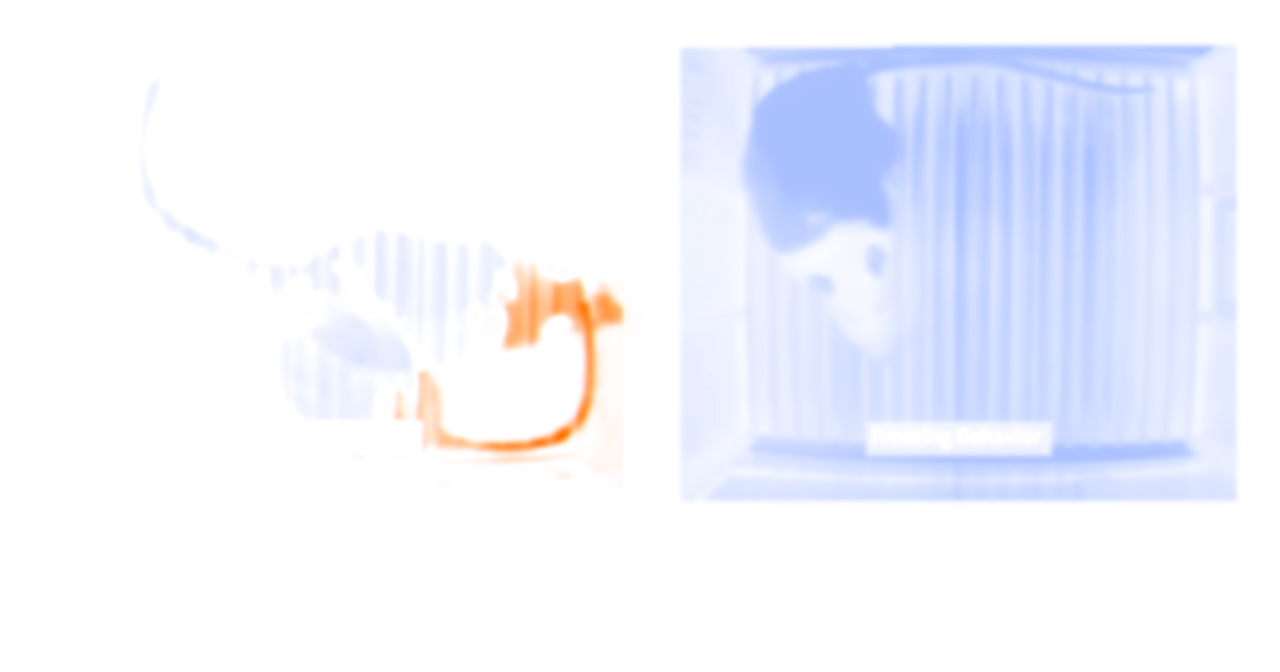

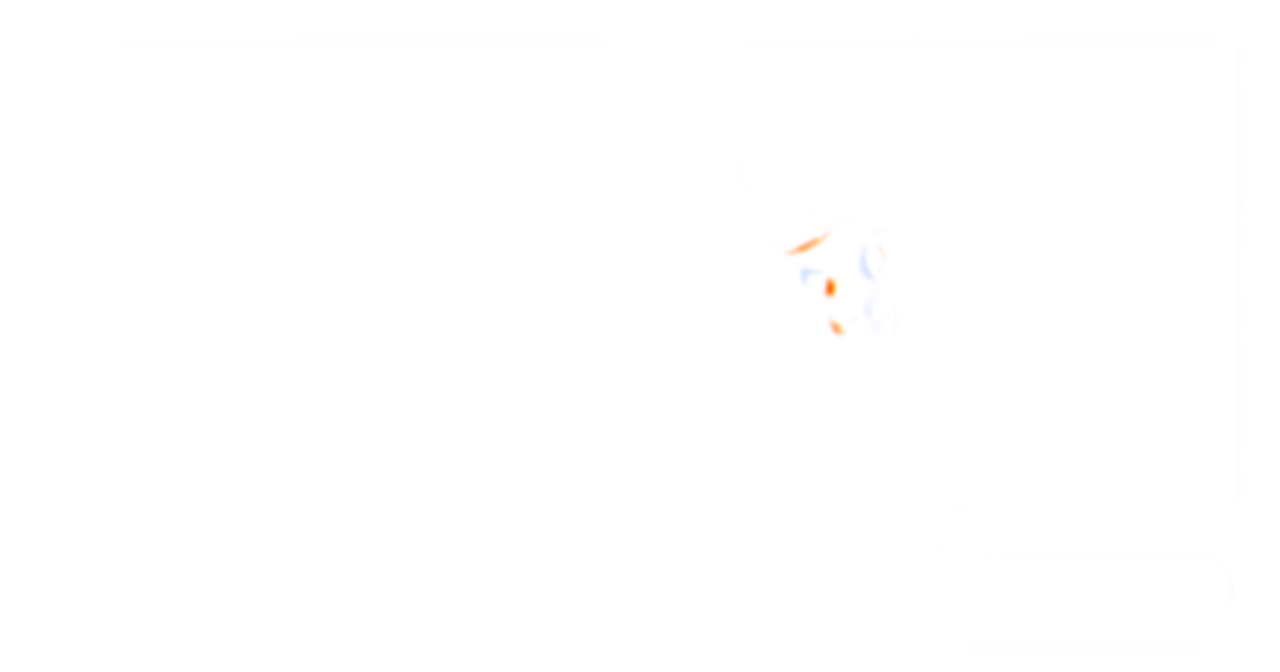

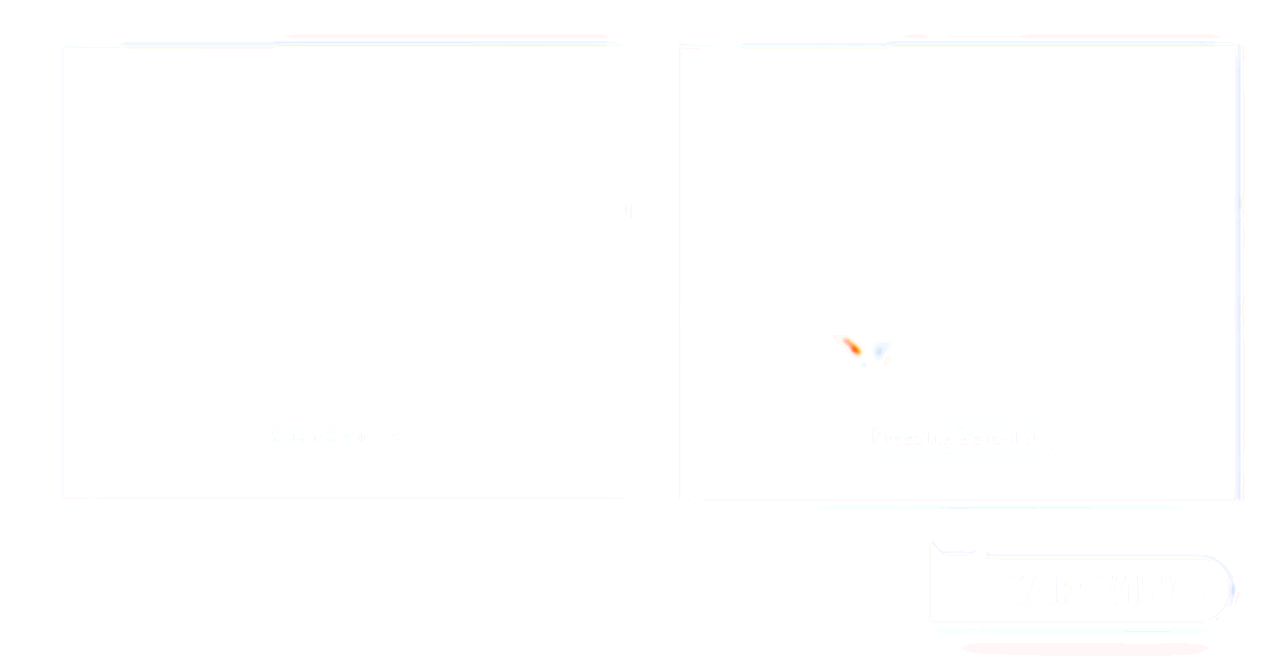

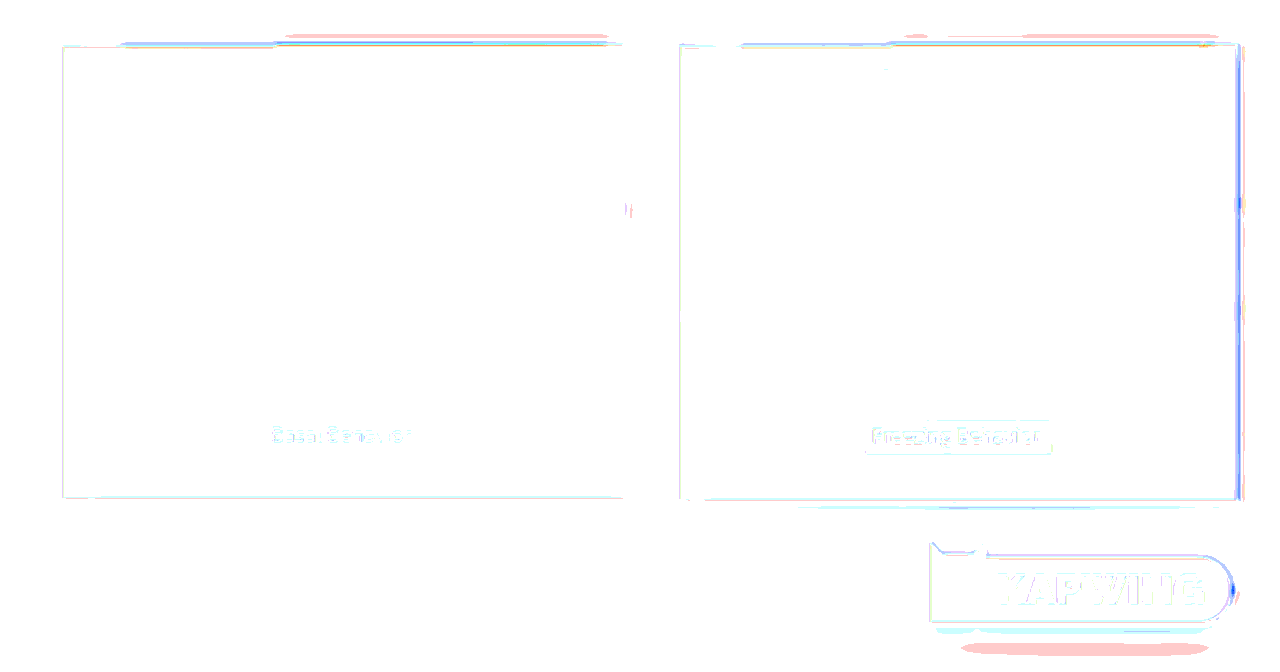

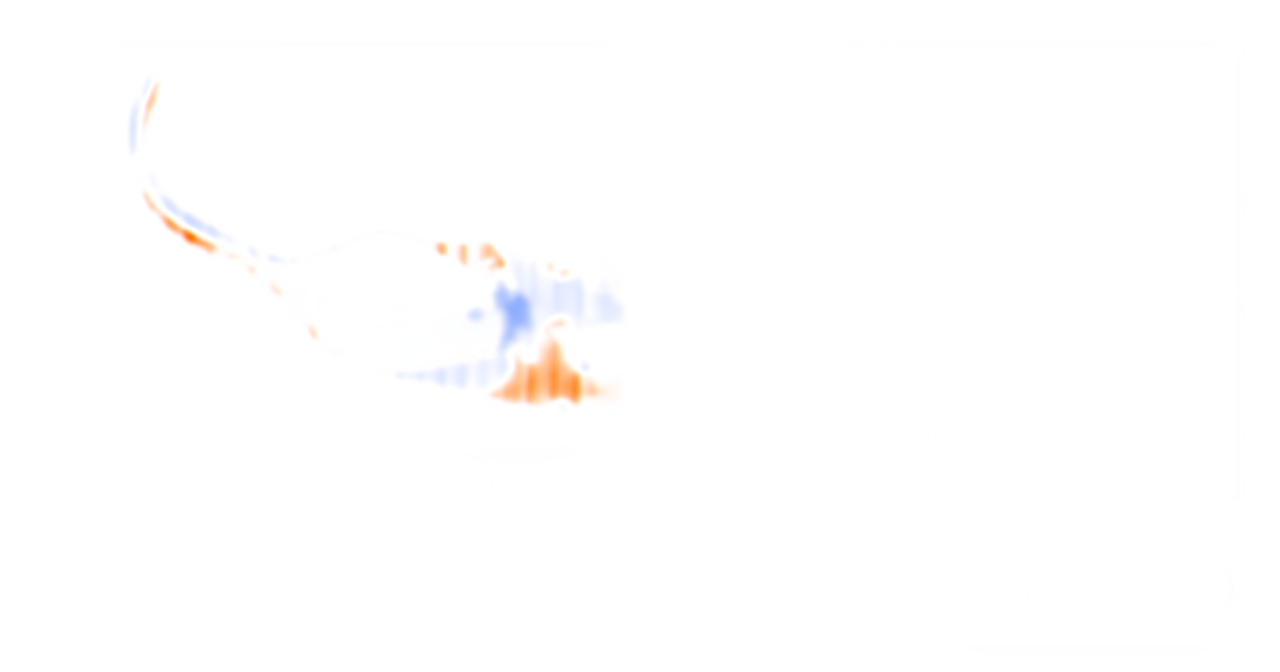

In [27]:
i = 0
for old,new in loader:
    # Generate the moving images and convert them to tensors.
    moving_image, input_fixed  = old.unsqueeze(0), new.unsqueeze(0)
    
    input_moving = moving_image.to(device).float()
  
    input_fixed  = input_fixed.to(device).float()
    
    # Run the data through the model to produce warp and flow field
    warp, flow = fpnet(input_moving, input_fixed)
    _flow = flow.detach().cpu().squeeze().permute(1,2,0).numpy()
    _flow = np.rint(_flow)
    _flow_img = flow2hsv(_flow,show_style=2)
    #_flow_img = draw_flow(moving_image.squeeze(),flow.detach().cpu().squeeze().permute(1,2,0).numpy())
    #_flow = flow.detach().cpu().squeeze().permute(1,2,0).numpy()
    #_flow_img = draw_flow(moving_image.squeeze(),_flow)
    if i >=5:
      break
    i += 1

    cv2_imshow(_flow_img)
    


In [28]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

current frame:  0


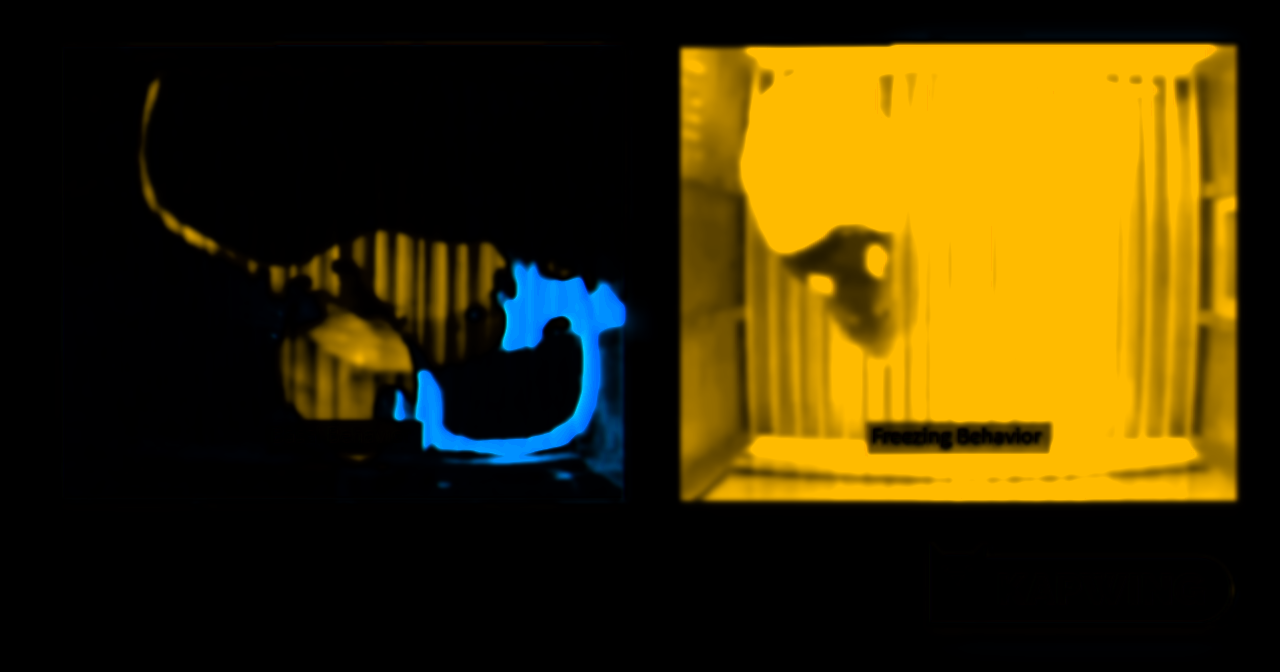

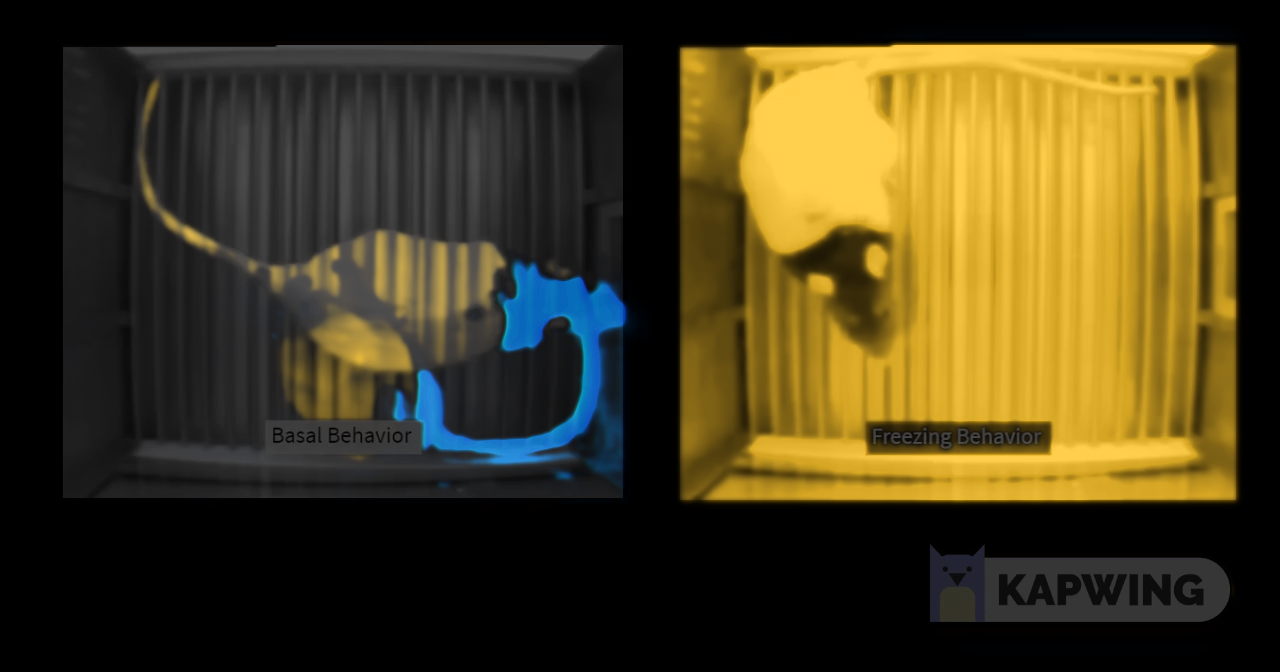

current frame:  100


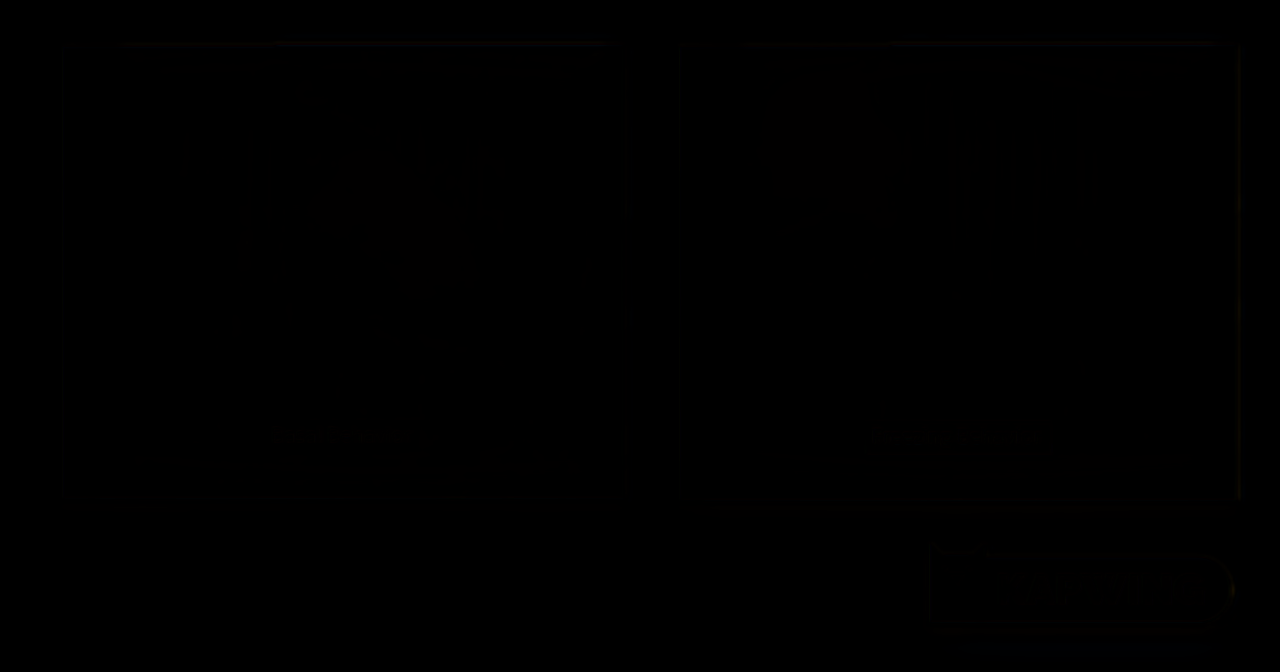

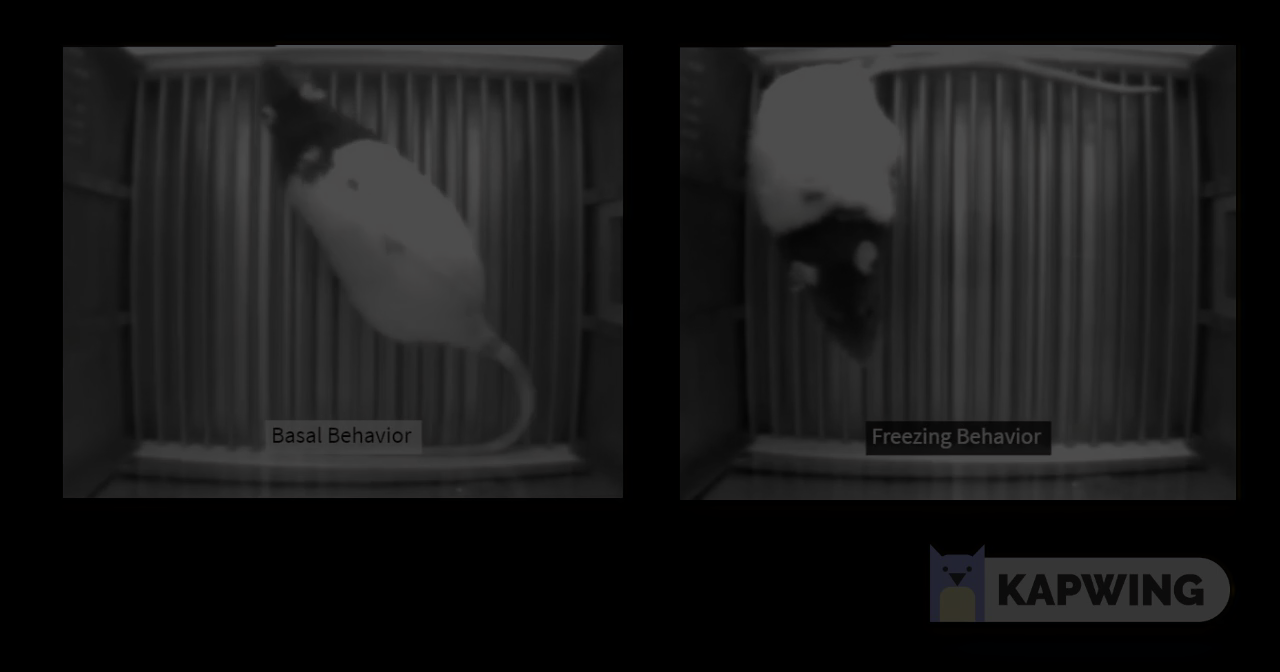

current frame:  200


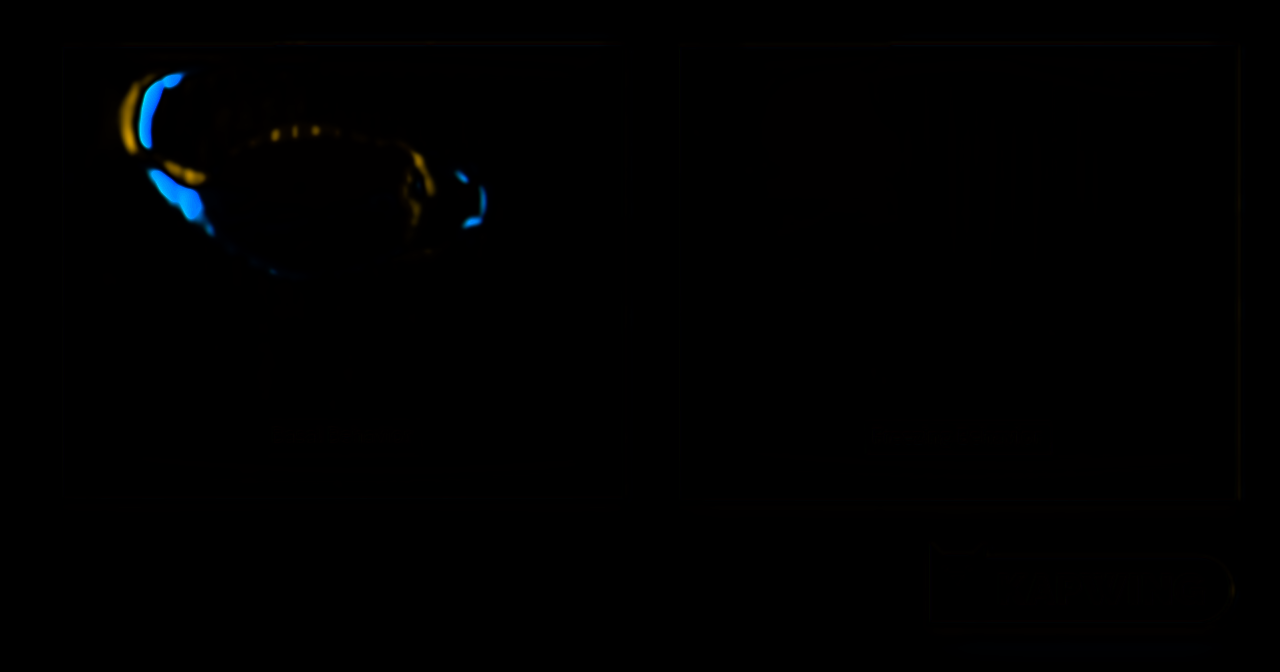

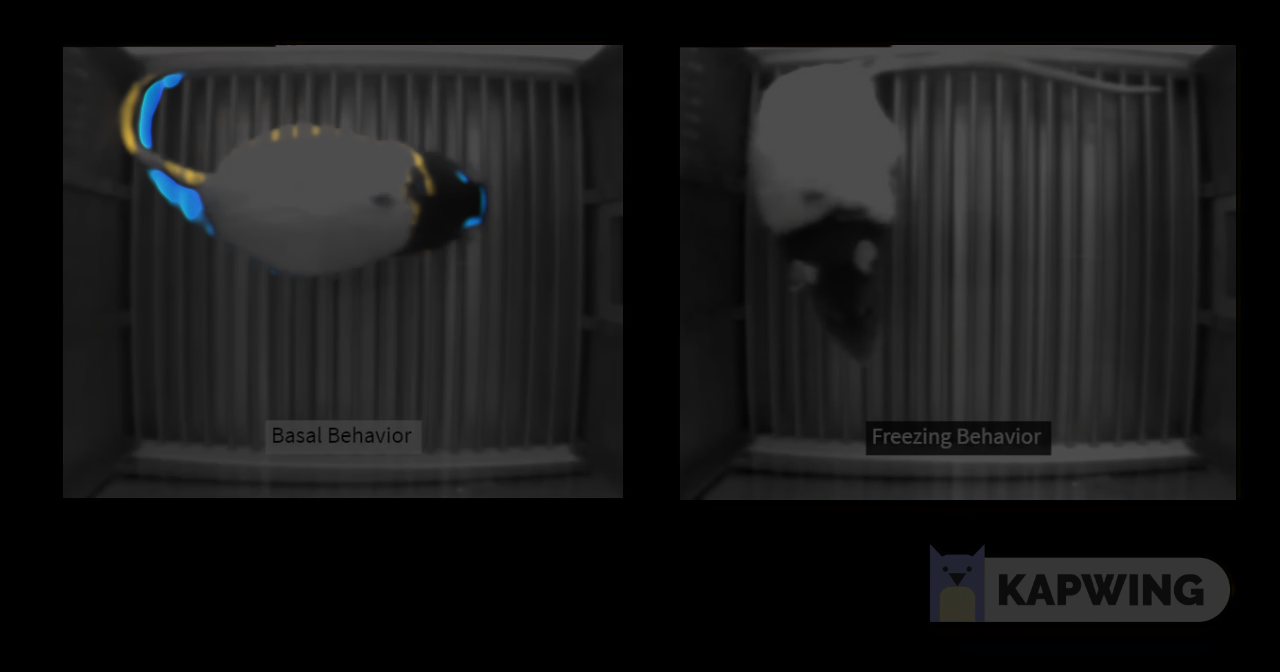

current frame:  300


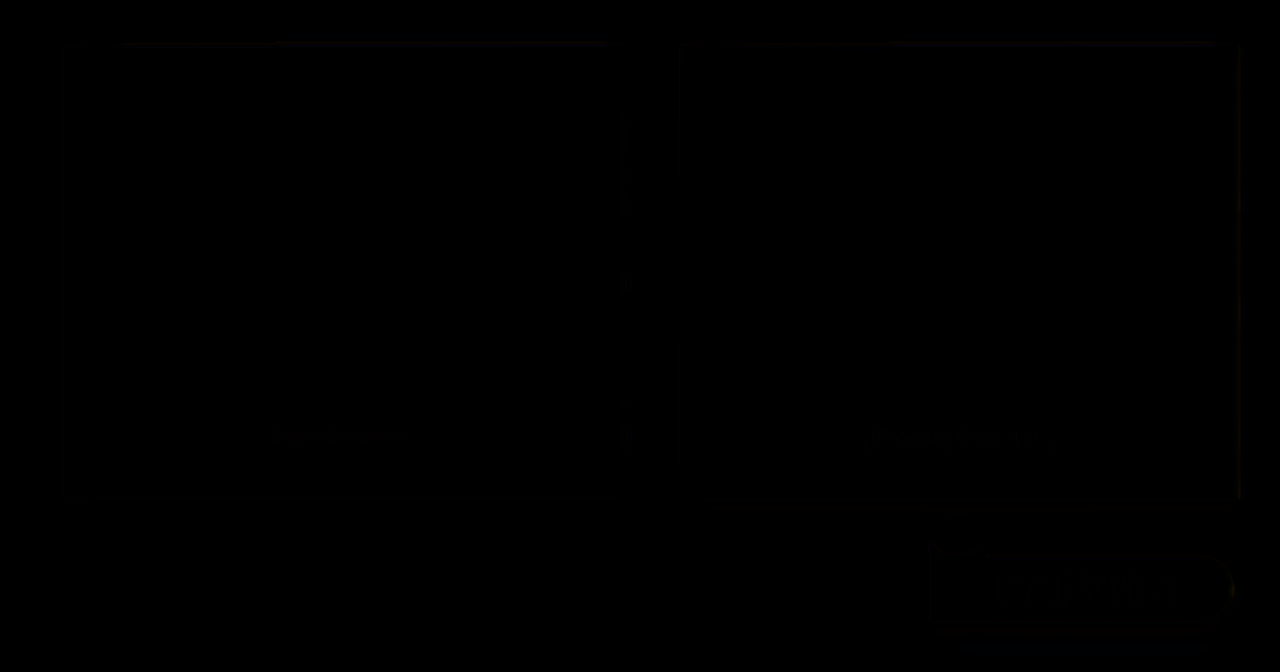

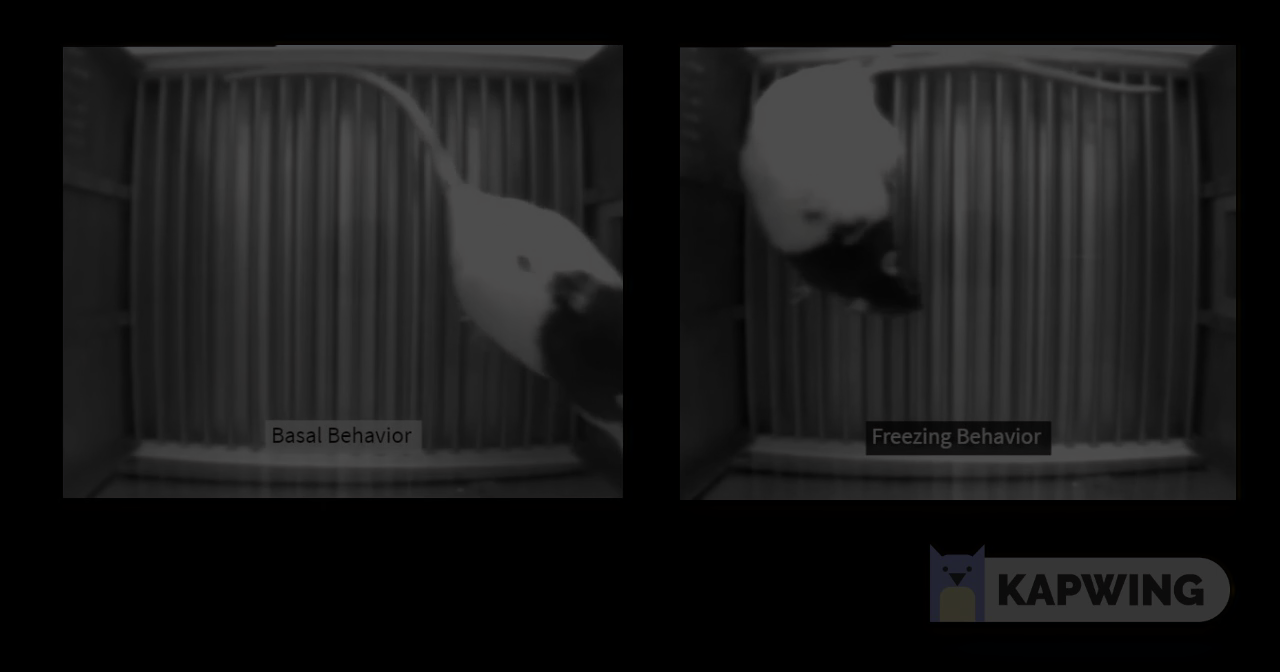

In [64]:
from random import randint
import sys
cam = cv2.VideoCapture(VIDEO_PATH)
ret, prev = cam.read()
width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
target_fps = int(cam.get(cv2.CAP_PROP_FPS))
if not ret:
    sys.exit(1)
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
video_writer = cv2.VideoWriter('overlay_output_results.mp4',
                                   cv2.VideoWriter_fourcc(*"mp4v"),
                                   target_fps,
                                   (width, height))
i_frames = 0
# folder saving the flo files
flows_folder = '/content/flows_results/flos'
if not os.path.exists(flows_folder):
    os.makedirs(flows_folder)

while cam.isOpened():
    ret, img = cam.read()
    if ret:
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      moving_image = torch.from_numpy(prevgray).unsqueeze(0).unsqueeze(0)  
      input_fixed = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
      input_moving = moving_image.to(device).float()

      input_fixed  = input_fixed.to(device).float()

      # Run the data through the model to produce warp and flow field
      warp, flow = fpnet(input_moving, input_fixed)
      _flow_c = flow.detach().cpu().squeeze().permute(1,2,0).numpy()
      #flows.append(_flow_c) # np.rint round to int
      flow_filename = os.path.join(flows_folder,f'flow_{i_frames:06}.flo')
      write_flow(flow_filename, _flow_c)
      _flow_img = draw_hsv(_flow_c)
      out_img = cv2.addWeighted(img,0.3,_flow_img,0.7,0.2)
      video_writer.write(out_img)
      if i_frames % 100 == 0:
          print('current frame: ',i_frames)
          cv2_imshow(_flow_img)
          cv2_imshow(out_img)
      prevgray = gray
      i_frames += 1
    else:
        break
      
cv2.destroyAllWindows()
cam.release()
video_writer.release()

In [ ]:
# install flowiz for read .flo optiocal flow files
!pip install flowiz -U

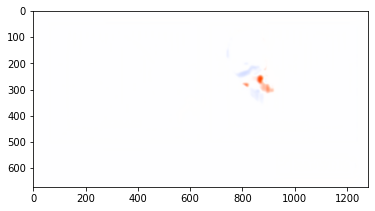

In [47]:
import glob
import flowiz as fz
flow_files = glob.glob('/content/flows_results/*.flo')
uv = fz.convert_from_file(flow_files[0])
plt.imshow(uv)

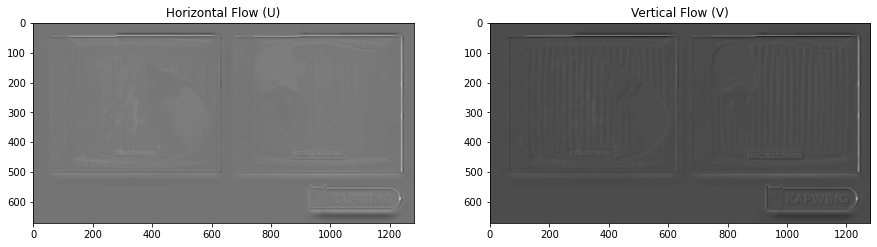

In [61]:
uv = fz.read_flow(flow_files[1])

f, axarr = plt.subplots(1,2)
f.set_size_inches(15, 5)

axarr[0].set_title('Horizontal Flow (U)')
axarr[0].imshow(uv[...,0],cmap=plt.get_cmap('binary'))
axarr[1].set_title('Vertical Flow (V)')
axarr[1].imshow(uv[...,1],cmap=plt.get_cmap('binary'))

In [ ]:
# Please uncomment the following file if you would like to convert flo files to png files and save them to a video file
#!python -m flowiz /content/flows_results/*.flo --outdir  /content/flows_results/png --videodir /content/flows_results/mp4

In [ ]:
#Download the flo result files
!zip -r flows_results.zip /content/flows_results
from google.colab import files
files.download('/content/flows_results.zip')

*Reference:* 

[VoxelMorph at TMI](https://arxiv.org/abs/1809.05231)   
[Diffeomorphic VoxelMorph at MedIA](https://arxiv.org/abs/1903.03545)   
[Neurite Library](https://github.com/adalca/neuron) - [CVPR](http://arxiv.org/abs/1903.03148)

https://github.com/voxelmorph/voxelmorph